In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
# from gridtools.hypnotoad_tools import *
# from gridtools.b2_tools import *
# from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Gridtools not found
Done


# Hermes IO

In [2]:
casestore = dict()

In [3]:
db = CaseDB()

toload = [
    # dict(name="1e19", id="d10d-anom_visc", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="2e19_neumann", id="d11b-d10d_2e19", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="3e19_neumann", id="d11d-d11b-3e19_try2", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="decaylength", id="d13a-d11b_decaylength", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="edgerec", id="d14b-edgerec_no_Tnfix", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="fluxlim1", id="d16-d15_d_fluxlim_1", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="fluxlim0.2", id="d15-d14b_d_fluxlim_default", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="fluxlim0.2_latest", id="d15b-rerun_latest_master", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="fluxlim_on", id="d17-d15_newdmodel_newfluxlim", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="fluxlim_off", id="d14br-rerun_latest_edgerecycling", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.942E+00 [m3]
CHECK: Total domain volume is 1.942E+00 [m3]


In [4]:
plt.close("all")
%matplotlib inline

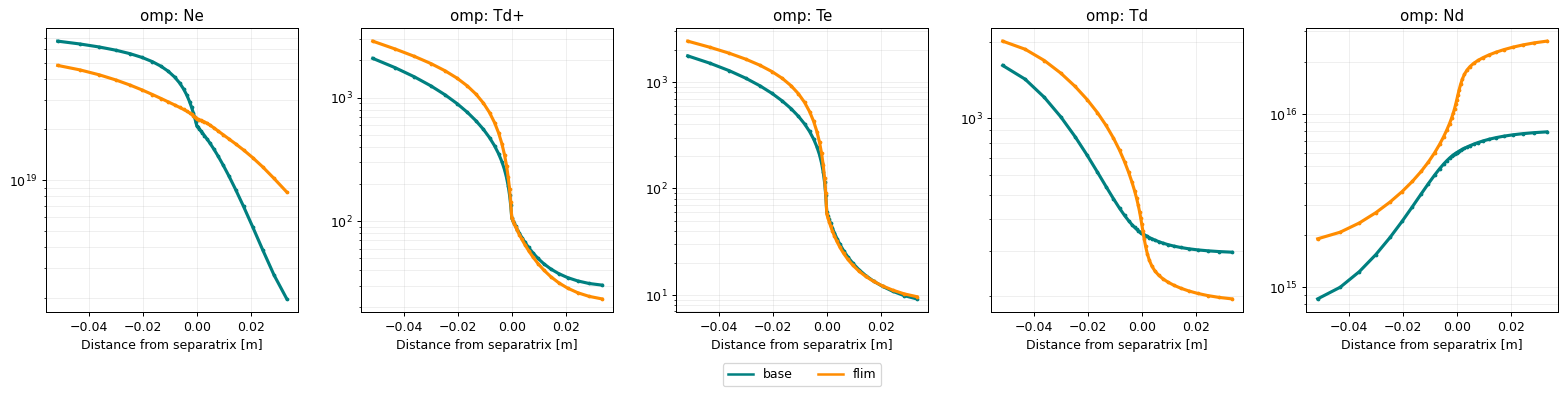

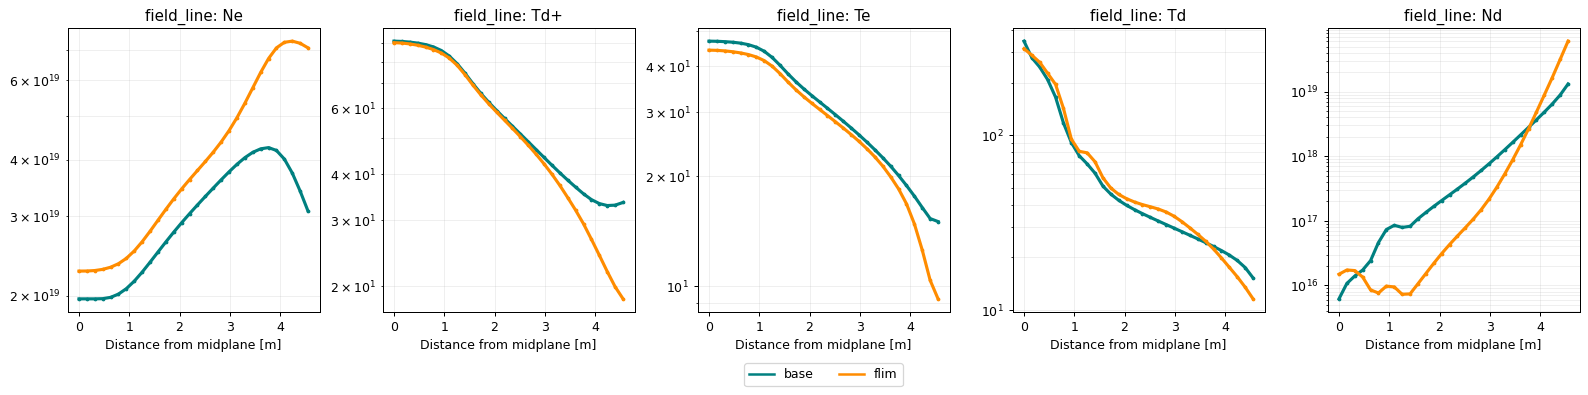

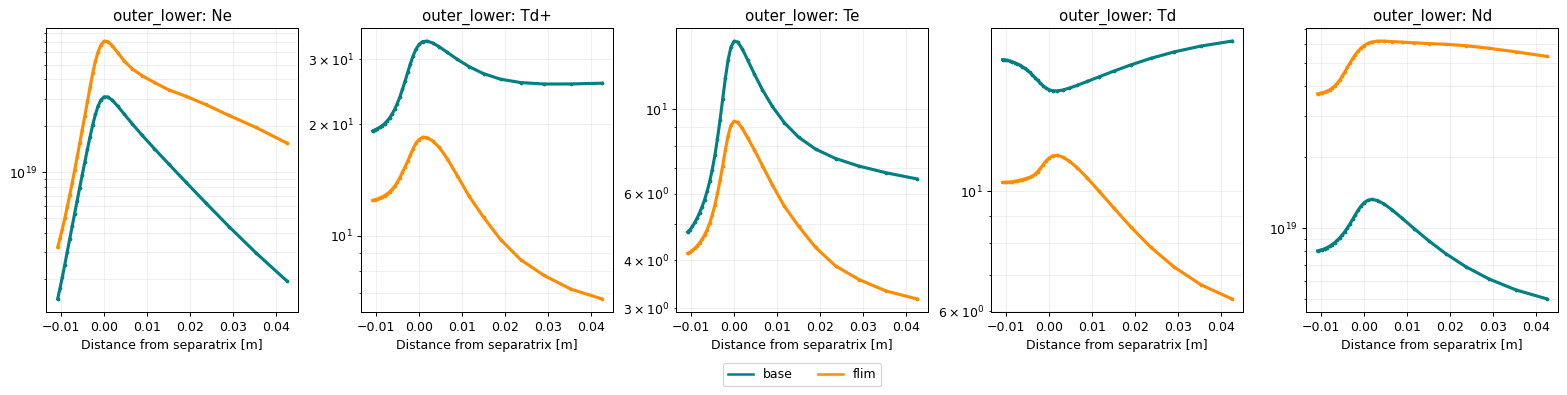

In [6]:
cases = dict()

cases["base"] = casestore["fluxlim_off"].ds.isel(t=-1, x = slice(2,-2))
cases["flim"] = casestore["fluxlim_on"].ds.isel(t=-1, x = slice(2,-2))

lineplot(
    cases = cases,
    clean_guards = False,
    regions = ["omp", "field_line", "outer_lower"],
    params = ["Ne", "Td+", "Te", "Td", "Nd"],
    # params = ["Pd+", "Pe", "Pd", "NVd+", "NVd"],
    dpi = 90
)

# Spatial distribution of the three limit factors

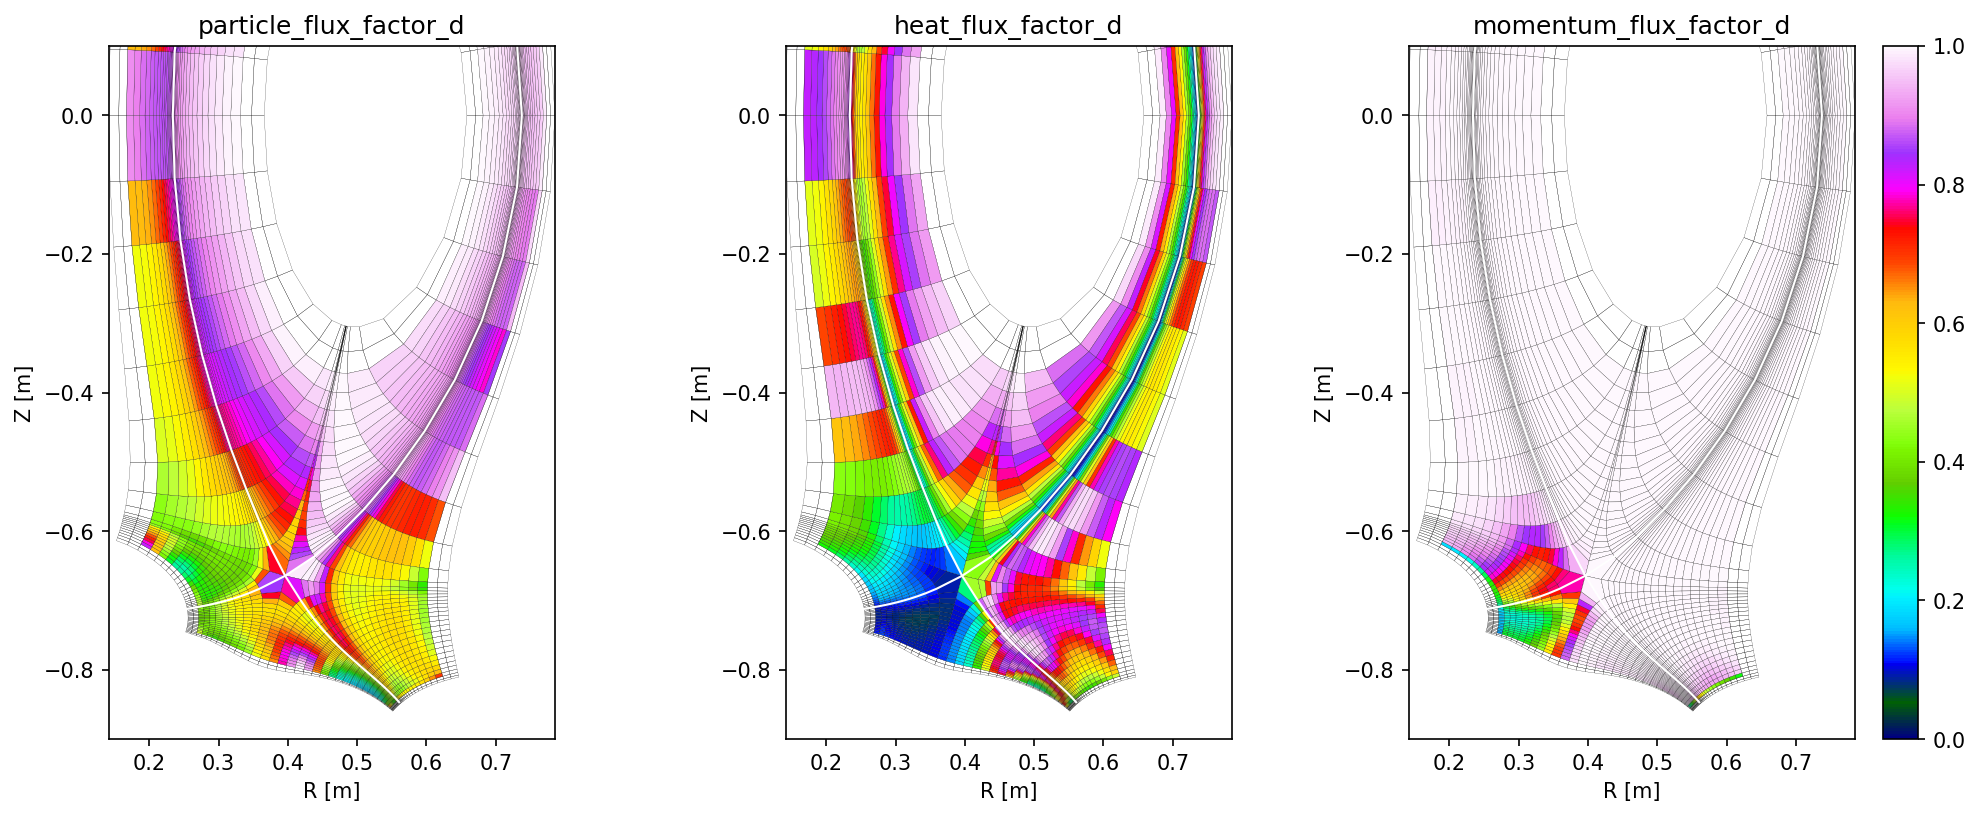

In [5]:
plt.close("all")
scale = 1.0
fig, axes = plt.subplots(1,3,figsize = (5.5*scale*3,6*scale), dpi = 150)
ds = casestore["fluxlim_on"].ds
for i, name in enumerate(["particle_flux_factor_d", "heat_flux_factor_d", "momentum_flux_factor_d"]):
    cbar = True if i == 2 else False
    ds[name].isel(t=-1).hermesm.clean_guards().bout.polygon(ax = axes[i], cmap = "gist_ncar",
                                                                    vmin = 0,
                                                                    vmax = 1,
                                                                    antialias = True,
                                                                    linewidth = 0.1,
                                                                    add_colorbar = cbar)
    
    axes[i].set_ylim(-0.9, 0.1)

# Time evolution

Text(0.5, 1.0, 'Non-weighted RMS of flux factors')

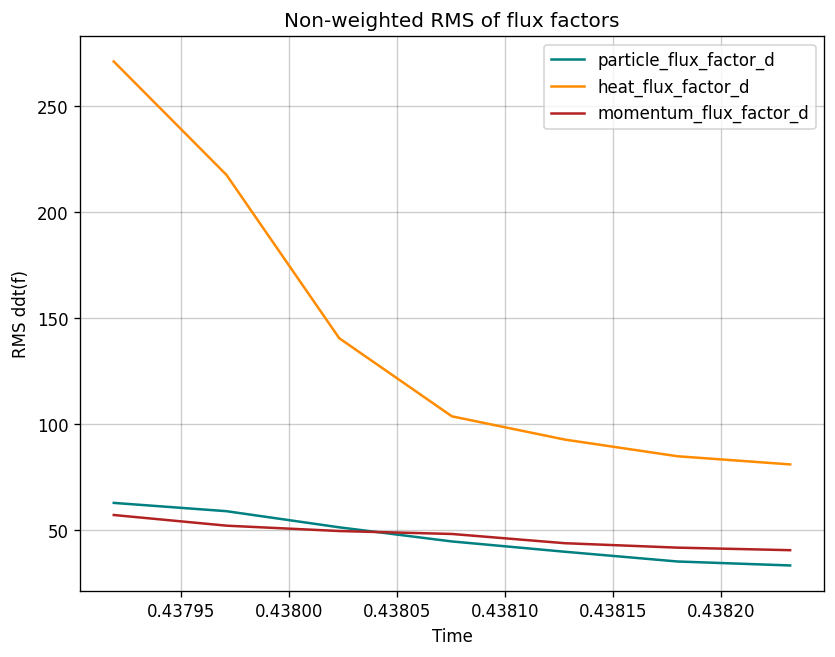

In [62]:
domain = ds.hermesm.select_region("all_noguards")

fig, ax = plt.subplots(figsize=(8, 6), dpi = 120)

def plot(param, label, **kwargs):
    derivative = domain[param].differentiate("t")
    rms = np.sqrt((derivative**2).mean(["x", "theta"]))
    ax.plot(domain["t"], rms, label = param, ls = "-", **kwargs)
    # ax.plot(domain["t"], domain[param].min(["x", "theta"]), ls = "--", **kwargs)
    # ax.plot(domain["t"], domain[param].max(["x", "theta"]), ls = "--", **kwargs)
    
plot("particle_flux_factor_d", "Particle flux", color = "teal")
plot("heat_flux_factor_d", "Particle flux", color = "darkorange")
plot("momentum_flux_factor_d", "Particle flux", color = "firebrick")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("RMS ddt(f)")
ax.grid(color = "k", alpha = 0.2)
ax.set_title("Non-weighted RMS of flux factors")

## Plot variation

In [81]:
diff = ds["particle_flux_factor_d"].hermesm.clean_guards().differentiate("t")

In [80]:
rms.metadata

AttributeError: 'DataArray' object has no attribute 'metadata'

Text(0.5, 0.98, 'Fluctuation RMS (as fraction)')

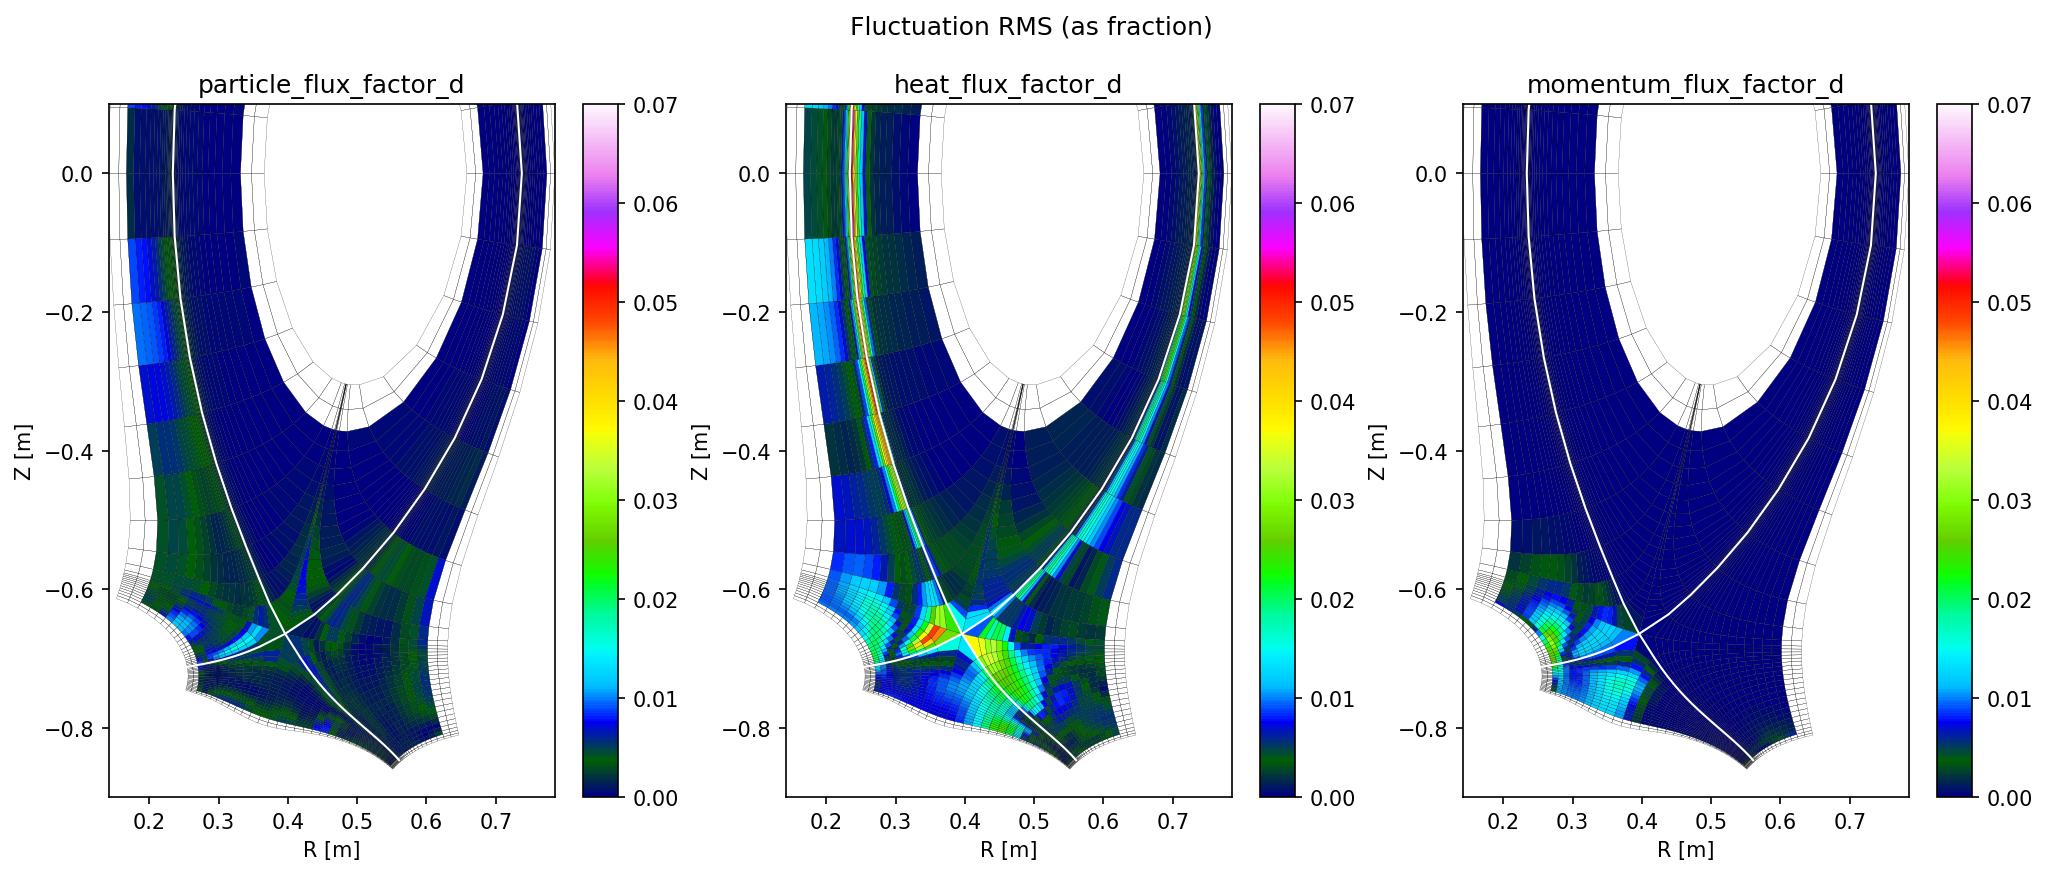

In [6]:
plt.close("all")
scale = 1
fig, axes = plt.subplots(1,3,figsize = (5.5*scale*3,6*scale), dpi = 150)

for i, name in enumerate(["particle_flux_factor_d", "heat_flux_factor_d", "momentum_flux_factor_d"]):
    cbar = True if i == 2 else False
    data = ds[name].hermesm.clean_guards()
    diff = data.diff("t")
    fractional = diff / data
    rms = np.sqrt((fractional**2).mean("t"))
    rms.attrs = data.attrs
    rms.bout.polygon(ax = axes[i], cmap = "gist_ncar",
                                                                    vmin = 0,
                                                                    vmax = 0.07,
                                                                    antialias = True,
                                                                    linewidth = 0.1,
                                                                    add_colorbar = True)
    
    axes[i].set_ylim(-0.9, 0.1)
    
fig.suptitle("Fluctuation RMS (as fraction)")

In [135]:
%matplotlib widget

In [ ]:
fig, ax = plt.subplots()
omp = fractional.hermesm.select_region("outer_midplane_a")
omp.coords

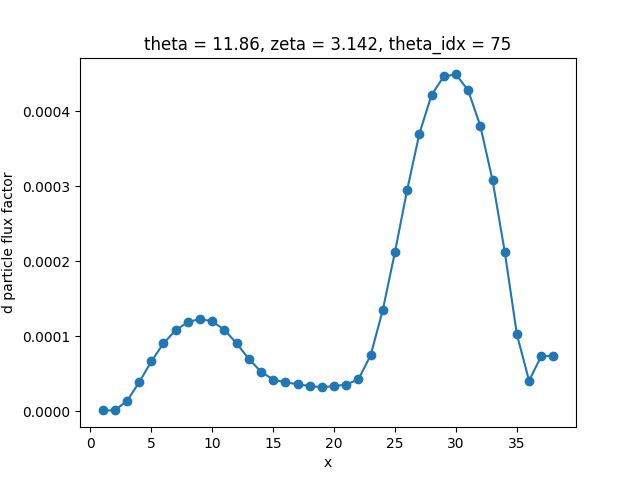

In [162]:
plt.close("all")
fig, ax = plt.subplots()

data = ds.hermesm.select_region("outer_midplane_a")["particle_flux_factor_d"].isel(x=slice(1,-1))
# diff = data.differentiate("t")
# rms = np.sqrt((diff**2).mean("t"))
# rms.attrs = data.attrs
# fractional = rms/data


diff = data.diff("t")
fractional = diff/data

rms = np.sqrt((fractional**2).mean("t"))
rms.attrs = data.attrs


# fractional.plot(ax = ax)
rms.plot(ax = ax, marker = "o")
# data.isel(t=-2).plot()
# xbout.plotting.animate.animate_line(data, ax = ax)

In [158]:
diff.isel(t=-1).values

array([ 0.01183915,  0.01183915,  0.21023983,  0.57902772,  0.93439799,
        1.19871468,  1.34743938,  1.36997832,  1.24510398,  0.95821885,
        0.53880968,  0.06455598, -0.38341546, -0.73418485, -0.9831092 ,
       -1.10476099, -1.10216341, -1.03503001, -0.90043769, -0.9471886 ,
       -0.97177557, -1.33328602, -2.03580881, -2.95978094, -4.00297844,
       -4.993952  , -5.71043613, -6.08611633, -6.16745603, -5.95850952,
       -5.46621711, -4.71081148, -3.710984  , -2.53601835, -1.2453165 ,
       -0.09897003, -1.20329137, -1.20329137])

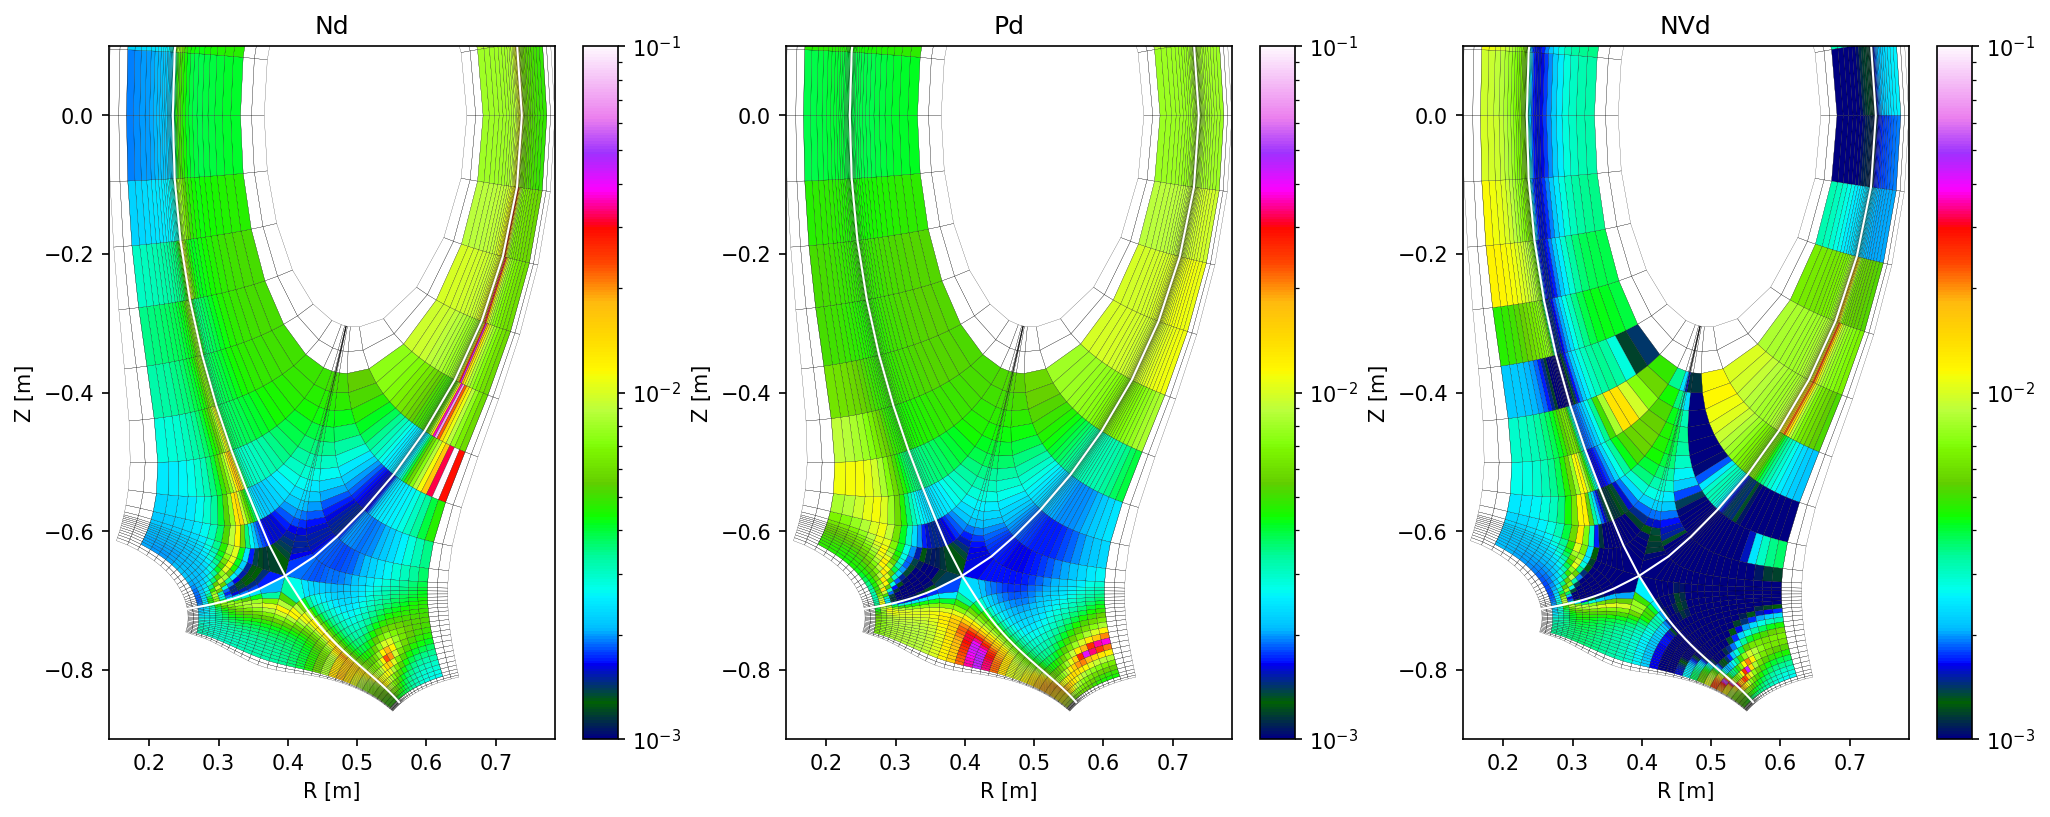

In [7]:
plt.close("all")
scale = 1.0
fig, axes = plt.subplots(1,3,figsize = (5.5*scale*3,6*scale), dpi = 150)

for i, name in enumerate(["Nd", "Pd", "NVd"]):
    cbar = True if i == 2 else False
    data = abs(ds[name].hermesm.clean_guards())
    diff = data.differentiate("t")
    rms = np.sqrt((diff**2).mean("t"))
    rms.attrs = data.attrs
    fractional = data / rms
    fractional.bout.polygon(ax = axes[i], cmap = "gist_ncar",
                                                                    vmin = 1e-3,
                                                                    vmax = 0.1,
                                                                    antialias = True,
                                                                    linewidth = 0.1,
                                                                    add_colorbar = True,
                                                                    logscale = True)
    
    axes[i].set_ylim(-0.9, 0.1)

In [6]:
ds = casestore["flixlim_afn"].ds
ds.data_vars

Data variables:
    Bxy                     (x, theta) float64 dask.array<chunksize=(8, 7), meta=np.ndarray>
    Dnnd                    (t, x, theta) float64 dask.array<chunksize=(7, 8, 7), meta=np.ndarray>
    Ed+_iz                  (t, x, theta) float64 dask.array<chunksize=(7, 8, 7), meta=np.ndarray>
    Ed+_rec                 (t, x, theta) float64 dask.array<chunksize=(7, 8, 7), meta=np.ndarray>
    Ed_pfr_recycle          (t, x, theta) float64 dask.array<chunksize=(7, 8, 7), meta=np.ndarray>
    Ed_sol_recycle          (t, x, theta) float64 dask.array<chunksize=(7, 8, 7), meta=np.ndarray>
    Ed_target_recycle       (t, x, theta) float64 dask.array<chunksize=(7, 8, 7), meta=np.ndarray>
    Edd+_cx                 (t, x, theta) float64 dask.array<chunksize=(7, 8, 7), meta=np.ndarray>
    EnergyFlow_d+_xlow      (t, x, theta) float64 dask.array<chunksize=(7, 8, 7), meta=np.ndarray>
    EnergyFlow_d+_ylow      (t, x, theta) float64 dask.array<chunksize=(7, 8, 7), meta=np.ndarray>


Text(0, 0.5, 'Wall time / simulation time')

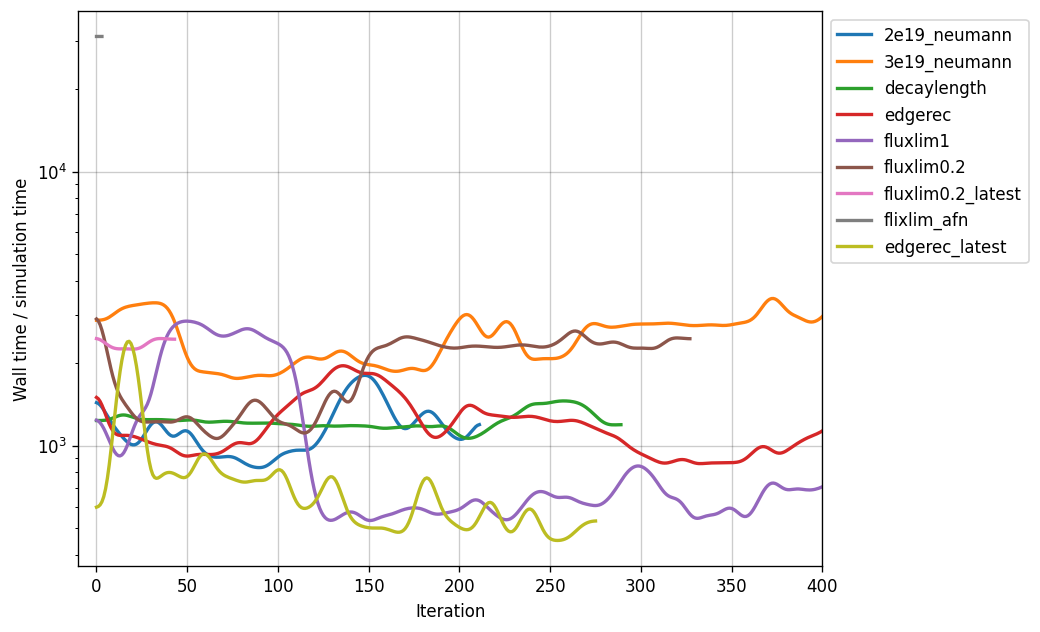

In [39]:
fig, ax = plt.subplots(figsize = (8,6), dpi = 120)

def smooth(x,w,recursion=0):
    out = scipy.ndimage.gaussian_filter(x, w)
    for i in range(recursion):
        out = scipy.ndimage.gaussian_filter(out, w)
    return out

for name in casestore:
    ds = casestore[name].ds.isel(t=slice(1,None))
    wtime = ds["wtime"]
    time = ds["t"]
    speed = wtime / time
    speed = smooth(speed, 5)
    ax.plot(speed, label = name, lw = 2)
    
ax.set_yscale("log")
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
ax.grid(c = "k", alpha = 0.2)
ax.set_xlim(-10,400)
ax.set_xlabel("Iteration")
ax.set_ylabel("Wall time / simulation time")
# ax.set_ylim(1.1e-4, 3e-3)